In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#might have problems with efficiency
#take any ak8 jet with 200 GeV that contain with deltaR (0.8) that contain generated Higgs
#compare to those that got tagged
#for now look for certain ak8 jets
#do the same W
#plot the pt of all jets that have a Higgs, then all those that are Higgs tagged
#generated Higgs are FatJet[FatJet.match(Higgs, deltaRCut=0.8)].deepTagMD_HbbvsQCD

In [3]:
class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("objecto", "Objects")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 72, 200, 2000)
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "pt_Htagged" :                hist.Hist("Counts", dataset_axis, pt_axis),
            "pt_Wtagged" :                hist.Hist("Counts", dataset_axis, pt_axis),
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]

        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content, 
            cutbased=df['Electron_cutBased'].content
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            mini_iso=df['IsoTrack_miniPFRelIso_all'], 
        )

          #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
       
        
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content, 
            btag=df['FatJet_btagDeepB'].content, 
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content, 
            fatjetid=df['FatJet_jetId'].content,
        )
        
        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        leadjetcut = (goodjets.pt.argmax())
        leadjet = goodjets[leadjetcut]
        
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        leadbjetcut = (bjets.pt.argmax())
        leadbjet = bjets[leadbjetcut]
        
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        leadnbjetcut = (nbjets.pt.argmax())
        leadnbjet = nbjets[leadnbjetcut]
        
        
        #ak8's
        goodfjcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0))
        goodfatjets = fatjets[goodfjcut]
        goodfatjetsh = goodfatjets[(goodfatjets.match(fatjets, deltaRCut=0.8))]
        htagcut = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromH > 0.8365))
        htagged = fatjets[htagcut]
        #leadhtagcut = (htagged.pt.argmax())
        #leadhtagged = htagged[leadhtagcut]
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fatjetid>0) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        #leadwtagcut = (wtagged.pt.argmax())
        #leadwtagged = wtagged[leadwtagcut] 
        
        #leptons
        
        veto_e_cut = (electrons.pt>5) & (abs(electrons.eta) < 2.4) & (electrons.cutbased  >= 1) & (electrons.mini_iso < 0.2)
        veto_e = electrons[veto_e_cut]
        
        veto_m_cut = (muons.pt > 5) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        veto_m = muons[veto_m_cut]
        
        veto_t_cut = (taus.pt > 20) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid == 8)
        veto_t = taus[veto_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.mini_iso < (0.1*isotracks.pt)) | (isotracks.mini_iso < 6))
        veto_it = isotracks[veto_it_cut]
        
        
        #MT
        dphi_leadbs_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjet.pt*metpt*(1-np.cos(dphi_leadbs_met)))
        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (df['GoodJet_pt'].counts >= 2)
        bjet_ps = (df['BJet_pt'].counts >= 1)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        h_sel =(htagged.counts > 0)
        wmd_sel = (wtagged_md.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        e_sel = (veto_e.counts == 0)
        m_sel = (veto_m.counts == 0)
        it_sel = (veto_it.counts == 0)
        t_sel = (veto_t.counts == 0)
        mt_sel = (min_mt_b_met > 200)

        
        #selection
        sel1 = presel & e_sel & m_sel & t_sel & it_sel & met_ps & ht_ps & njet_ps & bjet_ps & h_sel
        sel2 = presel & e_sel & m_sel & t_sel & it_sel & met_ps & ht_ps & njet_ps & bjet_ps & wmc_sel
    
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        
     
        

        #match jets
        '''jmatchleadH = leadhtagged.cross(goodjets)
        jmatchleadHDR = jmatchleadH.i0.p4.delta_r(jmatchleadH.i1.p4)
        jmatchleadHDPhi = abs(jmatchleadH.i0.p4.delta_phi(jmatchleadH.i1.p4))

        bmatchleadH = leadhtagged.cross(bjets)
        bmatchleadHDR = bmatchleadH.i0.p4.delta_r(bmatchleadH.i1.p4)
        bmatchleadHDPhi = abs(bmatchleadH.i0.p4.delta_phi(bmatchleadH.i1.p4))
        
        nbmatchleadH = leadhtagged.cross(nbjets)
        nbmatchleadHDR = nbmatchleadH.i0.p4.delta_r(nbmatchleadH.i1.p4)
        nbmatchleadHDPhi = abs(nbmatchleadH.i0.p4.delta_phi(nbmatchleadH.i1.p4))
        
        jmatchleadW = leadwtagged.cross(goodjets)
        jmatchleadWDR = jmatchleadW.i0.p4.delta_r(jmatchleadW.i1.p4)
        jmatchleadWDPhi = abs(jmatchleadW.i0.p4.delta_phi(jmatchleadW.i1.p4))

        bmatchleadW = leadwtagged.cross(bjets)
        bmatchleadWDR = bmatchleadW.i0.p4.delta_r(bmatchleadW.i1.p4)
        bmatchleadWDPhi = abs(bmatchleadW.i0.p4.delta_phi(bmatchleadW.i1.p4))
           
        nbmatchleadW = leadwtagged.cross(nbjets)
        nbmatchleadWDR = nbmatchleadW.i0.p4.delta_r(nbmatchleadW.i1.p4)
        nbmatchleadWDPhi = abs(nbmatchleadW.i0.p4.delta_phi(nbmatchleadW.i1.p4))

        #match phi
        
        jmatchMETDPhi = abs((leadjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        bmatchMETDPhi = abs((leadbjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        nonbmatchMETDPhi = abs((leadnbjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        HmatchMETDPhi = abs((leadhtagged.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        WmatchMETDPhi = abs((leadwtagged.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)'''


        
        
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        #FILL OUTPUTS

        output['pt_Htagged'].fill(objecto='Higgs tagged', pt=htagged.pt[sel1].flatten())
        output['pt_Wtagged'].fill(objecto='W tagged', pt=wtagged_mc.pt[sel2].flatten())
        

        
        
        

        return output

    
    def postprocess(self, accumulator):
        return accumulator
    

In [4]:
class WHhadProcessor2(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("objecto", "Objects")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 72, 200, 2000)
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "pt_genH":              hist.Hist("Counts", dataset_axis, pt_axis),
            "pt_genW":              hist.Hist("Counts", dataset_axis, pt_axis)
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]

        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content, 
            
        )
        #cutbased=df['Electron_cutBased'].content
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            mini_iso=df['IsoTrack_miniPFRelIso_all'], 
        )

          #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt=df['GenJet_pt'].content, 
            eta=df['GenJet_eta'].content, 
            phi=df['GenJet_phi'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['GenJet_mass'].content,
        )
        
        Bjets = JaggedCandidateArray.candidatesfromcounts(
            df['nBJet'],
            pt=df['BJet_pt'].content, 
            eta=df['BJet_eta'].content, 
            phi=df['BJet_phi'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['GenJet_mass'].content,
        )
       #btag=df['Jet_btagDeepB'].content,
        
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content,
            deepTagMD_HbbvsQCD=df['FatJet_deepTagMD_HbbvsQCD'].content,
            softdrop=df["FatJet_msoftdrop"].content, 
        )
        
        Bfatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nBFatJet'],
            pt=df['BFatJet_pt'].content, 
            eta=df['BFatJet_eta'].content, 
            phi=df['BFatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content, 
        )
        
        Higgs = JaggedCandidateArray.candidatesfromcounts(
            df['nH'],
            pt=df['GenH_pt'].content, 
            eta=df['GenH_eta'].content, 
            phi=df['GenH_phi'].content, 
            mass=df['GenH_phi'].content*0,
            
        )
        
        
        #ak4's
        
        
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        leadjetcut = (goodjets.pt.argmax())
        leadjet = goodjets[leadjetcut]
        
        bjcut = ((Bjets.pt>30) & (abs(Bjets.eta)<2.4)) #& (jets.jetid>0)) #& (jets.btag>0.4184)
        bjets = Bjets[bjcut]
        leadbjetcut = (bjets.pt.argmax())
        leadbjet = bjets[leadbjetcut]
        
        nonbjcut = ((Bjets.pt>30) & (abs(Bjets.eta)<2.4)) #& (jets.jetid>0)) #& (jets.btag<0.4184)
        nbjets = Bjets[nonbjcut]
        leadnbjetcut = (nbjets.pt.argmax())
        leadnbjet = nbjets[leadnbjetcut]
        
        
        #ak8's
        goodfjcut = ((fatjets.pt > 200)) #& (fatjets.fatjetid>0)
        goodfatjets = fatjets[goodfjcut]
                
        matchedFatJet = goodfatjets[goodfatjets.match(Higgs, deltaRCut=0.8)] # this selects all jets that have a Higgs inside
        passing_matchedFatJet = goodfatjets[(goodfatjets.match(Higgs, deltaRCut=0.8) & (goodfatjets.deepTagMD_HbbvsQCD>0.8365))]
        #hgen = goodfatjets[goodfatjets.match(Higgs, deltaRCut=0.8)].deepTagMD_HbbvsQCD
        
        
        #leptons
        
        veto_e_cut = (electrons.pt>5) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.2) #& (electrons.cutbased  >= 1)
        veto_e = electrons[veto_e_cut]
        
        veto_m_cut = (muons.pt > 5) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        veto_m = muons[veto_m_cut]
        
        veto_t_cut = (taus.pt > 20) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid == 8)
        veto_t = taus[veto_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.mini_iso < (0.1*isotracks.pt)) | (isotracks.mini_iso < 6))
        veto_it = isotracks[veto_it_cut]
        
        
        #MT
        dphi_leadbs_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjet.pt*metpt*(1-np.cos(dphi_leadbs_met)))
        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (df['GoodJet_pt'].counts >= 2)
        bjet_ps = (df['BJet_pt'].counts >= 1)
        ht_ps = (ht > 300)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps 
        e_sel = (veto_e.counts == 0)
        m_sel = (veto_m.counts == 0)
        it_sel = (veto_it.counts == 0)
        t_sel = (veto_t.counts == 0)
        mt_sel = (min_mt_b_met > 200)

        
        #selection
        sel3 = presel & e_sel & m_sel & t_sel & it_sel & met_ps & ht_ps & njet_ps & bjet_ps
        sel4 = presel & e_sel & m_sel & t_sel & it_sel & met_ps & ht_ps & njet_ps & bjet_ps

        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        
     
        

        #match jets
        '''jmatchleadH = leadhtagged.cross(goodjets)
        jmatchleadHDR = jmatchleadH.i0.p4.delta_r(jmatchleadH.i1.p4)
        jmatchleadHDPhi = abs(jmatchleadH.i0.p4.delta_phi(jmatchleadH.i1.p4))

        bmatchleadH = leadhtagged.cross(bjets)
        bmatchleadHDR = bmatchleadH.i0.p4.delta_r(bmatchleadH.i1.p4)
        bmatchleadHDPhi = abs(bmatchleadH.i0.p4.delta_phi(bmatchleadH.i1.p4))
        
        nbmatchleadH = leadhtagged.cross(nbjets)
        nbmatchleadHDR = nbmatchleadH.i0.p4.delta_r(nbmatchleadH.i1.p4)
        nbmatchleadHDPhi = abs(nbmatchleadH.i0.p4.delta_phi(nbmatchleadH.i1.p4))
        
        jmatchleadW = leadwtagged.cross(goodjets)
        jmatchleadWDR = jmatchleadW.i0.p4.delta_r(jmatchleadW.i1.p4)
        jmatchleadWDPhi = abs(jmatchleadW.i0.p4.delta_phi(jmatchleadW.i1.p4))

        bmatchleadW = leadwtagged.cross(bjets)
        bmatchleadWDR = bmatchleadW.i0.p4.delta_r(bmatchleadW.i1.p4)
        bmatchleadWDPhi = abs(bmatchleadW.i0.p4.delta_phi(bmatchleadW.i1.p4))
           
        nbmatchleadW = leadwtagged.cross(nbjets)
        nbmatchleadWDR = nbmatchleadW.i0.p4.delta_r(nbmatchleadW.i1.p4)
        nbmatchleadWDPhi = abs(nbmatchleadW.i0.p4.delta_phi(nbmatchleadW.i1.p4))

        #match phi
        
        jmatchMETDPhi = abs((leadjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        bmatchMETDPhi = abs((leadbjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        nonbmatchMETDPhi = abs((leadnbjet.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        HmatchMETDPhi = abs((leadhtagged.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)
        WmatchMETDPhi = abs((leadwtagged.phi - df["MET_phi"] + np.pi) % (2 * np.pi) - np.pi)'''


        
        
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137* 1000

        #FILL OUTPUTS
        output['pt_genH'].fill(objecto='gen Higgs', pt=passing_matchedFatJet.pt[sel3].flatten())
        output['pt_genW'].fill(objecto='gen W', pt=goodfatjets.pt[sel3].flatten())
        

        
        
        

        return output

    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
fileset_sig = {'mC750_l1': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/WH_had_750_1__nanoAOD/merged/WH_had_750_1__nanoAOD_1.root']}
fileset_gen = {'WHgen': ['/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_1.root', 
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_2.root',
                           '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_3.root',
                           '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_4.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_5.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_6.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_7.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_8.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_9.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_10.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_11.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_12.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_13.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_14.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_15.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_16.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_17.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_18.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_19.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_20.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_21.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_22.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_23.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_24.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_25.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_26.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_27.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_28.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_29.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_30.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_31.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_32.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_33.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_34.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_35.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_36.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_37.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_38.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_39.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p11/WH_had_750_1_nanoAOD/nanoSkim_40.root',
                           ]}
fileset_back = {'W+Jets': ['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-100To200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-200To400_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-400To600_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-600To800_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-800To1200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-1200To2500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__WJetsToLNu_HT-2500ToInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                         '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__WJetsToLNu_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                          ],
                'QCD':[#'/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       #'/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv96/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                        '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                    ],
            'TTJets':['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                       '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root'
                   ],
            "ZNuNu":['/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-100To200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-1200To2500_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-200To400_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/merged/background__ZJetsToNuNu_HT-400To600_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-600To800_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root',
                     '/hadoop/cms/store/user/mbryson/WH_hadronic/WH_had_750_1/nanoAOD/MBv93/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/merged/background__ZJetsToNuNu_HT-800To1200_13TeV-madgraph__RunIISummer16NanoAODv7-PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1_1.root'
                     ]
               }


output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_gen = processor.run_uproot_job(fileset_gen,
                                    treename='Events',
                                    processor_instance=WHhadProcessor2(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                     )
#output_back = processor.run_uproot_job(fileset_back,
#                                    treename='Events',
#                                    processor_instance=WHhadProcessor(),
#                                    executor=processor.futures_executor,
#                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
#                                    chunksize=500000,
#                                 )

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=1.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=1.0), HTML(value='')))

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=40.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=40.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


ValueError: Found numerator larger than denominator while calculating binomial uncertainty

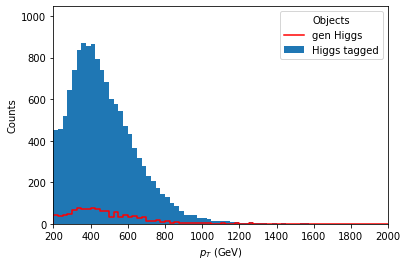

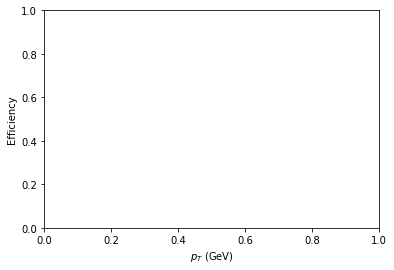

In [28]:
hist.plot1d(output_sig["pt_Htagged"], stack=True)
hist.plot1d(output_gen["pt_genH"], line_opts={'color':'r'})

# make ratio plot
output_sig["pt_Htagged"].label = "Efficiency"
hist.plotratio(
num=output_sig["pt_Htagged"].sum("objecto"),
denom=output_gen["pt_genH"].sum("objecto"),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='clopper-pearson')


/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='Efficiency'>

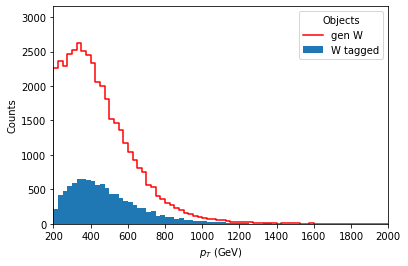

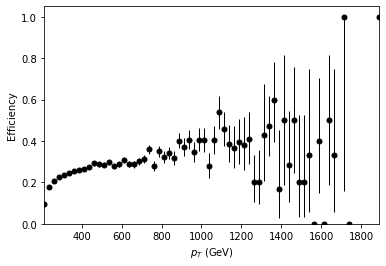

In [29]:
hist.plot1d(output_sig["pt_Wtagged"], stack=True)
hist.plot1d(output_gen["pt_genW"], line_opts={'color':'r'})

# make ratio plot
output_sig["pt_Wtagged"].label = "Efficiency"
hist.plotratio(
num=output_sig["pt_Wtagged"].sum("objecto"),
denom=output_gen["pt_genW"].sum("objecto"),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='clopper-pearson')